In [30]:
from random import choice
import matplotlib.pyplot as plt
from math import(atan2,erfc,erf,log10)
from numpy import (sin, cos, array, pi, sqrt,hsplit, argmin,arctan,arange,e, arange)
from numpy.random import normal
import matplotlib

In [31]:
f = 1e9                 # частота дескретизации 
F = 1e7                 # частота чипа 
T = 1e-6                # длительность передачи символа 
sigma = 8               # мощность шума
nsignals = 500           # количество символов
n = nsignals*2          # количество бит 

bits = [choice([(-1,-1),(-1,1),(1,-1),(1,1)]) for i in range(nsignals)]

In [32]:
quantity_of_counts_on_chip =  round((1/F)/(1/f))
quantity_of_chips_on_2bit = int(T/(1/F))
quantity_of_counts_2bit = quantity_of_chips_on_2bit*quantity_of_counts_on_chip
N = int(quantity_of_chips_on_2bit*nsignals)     
quantity_of_counts_all = int(N*quantity_of_counts_on_chip)

counts_on_chip = [t*(1/f) for t in range(0,quantity_of_counts_on_chip)]         
counts_time = [t*(1/f) for t in range(0,quantity_of_counts_all)] 
counts_on_2bit = [t*(1/f) for t in range(0,quantity_of_counts_2bit)]

#Опорные символы 
SIN = [sin(2*pi*F*t) for t in counts_on_2bit] 
COS = [cos(2*pi*F*t) for t in counts_on_2bit]
SIN=array(SIN).ravel()
COS=array(COS).ravel()

print('Частота дискретизации f: ',f)
print('Частота чипа (синусоиды) F :',F)
print('Время передачи символа T :',T)
print('Количество симсолов nsignals:',nsignals)
print()
print('Количество отсчетов на чип:',quantity_of_counts_on_chip)
print()
print('Количество чипов на 2 бита: ',quantity_of_chips_on_2bit )
print('Количество отсчетов на 2 бита: ',quantity_of_counts_2bit)
print()
print('Общее количество чипов: ', N)
print('Общее количество отсчетов на все сообщение: ',quantity_of_counts_all )
#print('Биты для передачи: ',bits)

Частота дискретизации f:  1000000000.0
Частота чипа (синусоиды) F : 10000000.0
Время передачи символа T : 1e-06
Количество симсолов nsignals: 500

Количество отсчетов на чип: 100

Количество чипов на 2 бита:  10
Количество отсчетов на 2 бита:  1000

Общее количество чипов:  5000
Общее количество отсчетов на все сообщение:  500000


In [33]:
def drawGrphs(message,bits,new_bits):

    
    #####################################    
    matplotlib.rcParams['figure.figsize'] = 15, 15
    plt.plot(counts_time,message,'green')
    #####################################  

    ####################################
    impl_new_bits= []
    impl_bits= []

    for i in range(nsignals):
        arr1 = quantity_of_counts_2bit*[1]
        arr1 = [arr1[k]*bits[i] for k in range(quantity_of_counts_2bit)]
        impl_new_bits += arr1
    
        arr2 = quantity_of_counts_2bit*[1]
        arr2 = [arr2[k]*new_bits[i] for k in range(quantity_of_counts_2bit)]
        impl_bits += arr2
    
    plt.subplot(3,1,1)
    b=plt.plot(counts_time,impl_bits,'blue') 
    plt.subplot(3,1,2)
    a=plt.plot(counts_time,impl_new_bits,'red') 
    plt.subplot(3,1,3)
    plt.plot(counts_time,message,'green')
    
    plt.show()

In [34]:
def modulatorQPSK(sigma,bits):
        
    message = []
    for d in bits:
        message+=[1/sqrt(2)*(  d[0]*COS + d[1]*SIN  )]
    message=array(message).ravel()
    
    noise = normal(0,sigma,quantity_of_counts_all)        # Гауссовский шум с заданой SIGMA
    
    message_noise = array(message + noise)
     
    return message_noise

In [35]:
def deModulatorQPSK(nsignals,message_noise):
      
    arrd_sing = hsplit(message_noise,nsignals)

    phStdrt = [(1,1),(-1,1),(-1,-1),(1,-1)]

    X = 0
    Y = 0
    new_bits = []


    for i in range(nsignals):
        X = (arrd_sing[i] * COS).sum()
        Y = (arrd_sing[i] * SIN).sum()
        phArrd = atan2(Y,X)
        id_ph = argmin([abs(pi/4 - phArrd), abs(3*pi/4 - phArrd),abs(-3*pi/4 - phArrd),abs(-pi/4 - phArrd)])
        new_bits += phStdrt[id_ph]
        X = 0
        Y = 0
        
    new_bits = array(new_bits)  
    
    return new_bits

In [36]:
message = modulatorQPSK(sigma,bits)
new_bits = deModulatorQPSK(nsignals,message)
bits = array(bits).ravel()

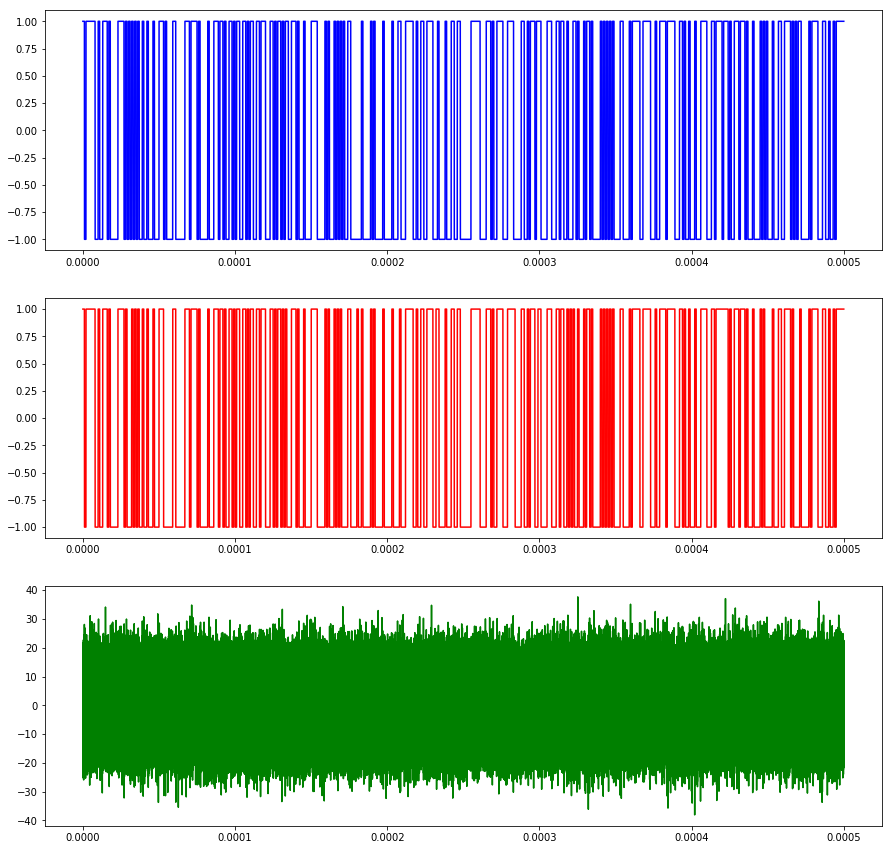

In [37]:
drawGrphs(message,bits,new_bits)

In [38]:
# Теоретическая и практическая вероятность ошибки
E = T/2
No = 2*sigma**2 / f
SN = 2*E/No
ErrTheor = erfc(sqrt(SN/4))/2                      

PError1= 100*list((bits*new_bits)).count(-1) / n

print('Сигнал-шум:',10*log10(SN))
print('E:',E)
print('N0:',No)
print('Теоретическая вероятность ошибки',round(100*ErrTheor,1),'%')
print('Практическая вероятность ошибки:',PError1,'%')

Сигнал-шум: 8.927900303521316
E: 5e-07
N0: 1.28e-07
Теоретическая вероятность ошибки 2.4 %
Практическая вероятность ошибки: 2.7 %


In [39]:
# Графическое представление

In [26]:
E = T/2              
arrSN = arange(-5,15,1)

In [27]:
#С помощью дополнительной функции ошибок erfc = 1 - erf нахождение теоретических значений Pошибки
arrErrThr = [erfc(sqrt(10**(SN/10)/4))/2 for SN in arrSN]

In [28]:
#Расчет средней практической ошибки
quantity_for_medium = 100
arrErrPrt = []

for SN in arrSN:
    Pm = 0
    sig=sqrt((T*f)/(2*10**(SN/10)))   #!!!!
    print(sig)
    for i in range(quantity_for_medium):
        bits = [choice([(-1,-1),(-1,1),(1,-1),(1,1)]) for i in range(nsignals)]
        mes = modulatorQPSK(sig ,bits)
        new_bits = deModulatorQPSK(nsignals ,mes)
        np_bits =  array(bits).ravel()
        
        Pm += list((np_bits*new_bits)).count(-1)
        
    Pm /= (quantity_for_medium*n)
    arrErrPrt += [Pm]

39.76353643835253
35.43928915419707
31.58529970547121
28.150427993736734
25.089095358284318
22.360679774997898
19.928976826775145
17.761719292909024
15.830148982673414
14.108635131604638
12.574334296829354
11.206887238456494
9.98814876483345
8.901946956877223
7.933868576533667
7.0710678118654755
6.302095820932435
5.616748812614791
5.005932648504533
4.461542169214011


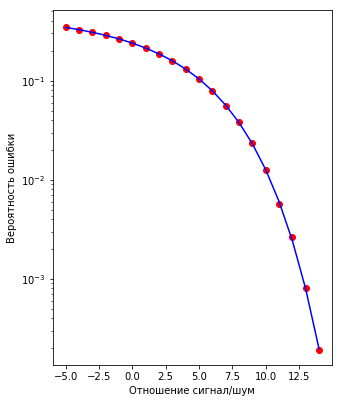

In [71]:
matplotlib.rcParams['figure.figsize'] = 5, 30
gr = plt.subplot(4,1,1)   
gr.set_xlabel('Отношение сигнал/шум')
gr.set_ylabel('Вероятность ошибки')
#Практика
plt.scatter(arrSN,arrErrPrt, marker='o', c='r', edgecolor='r')
#Теория
plt.plot(arrSN,arrErrThr,'blue')
#gr.set_xscale('log')
gr.set_yscale('log')